In [95]:
from data.datamodule import GraphSupervisedDataModule
from model.graph_encoder import CGCNN, PaiNN
from model.clamp import CLaMPLite
import torch
from torch import nn
from torch.nn import functional as F
from pytorch_lightning import Trainer
import pytorch_lightning as pl
from typing import Any, Dict, List, Mapping
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint



# Load datamodule

In [96]:
dm = GraphSupervisedDataModule(
    data_path="/home/yj/PycharmProjects/MIT/CLaMP/dft_3d_2021_data",
    batch_size=64,
    num_workers=4,
    tokenizer_model='bert-base-uncased',
    label='optb88vdw_total_energy',
    task='regression',
)
dm.setup()
dm.num_classes = 1

# Load Model

In [97]:
# # Instantiate the encoders and tokenizers
# if self.hparams.fine_tune_from is not None:
#     if self.hparams.base_model_type == 'clamp':
#         model = CLaMPLite.load_from_checkpoint(self.hparams.fine_tune_from, map_location={'cuda:0': 'cpu'})
#     elif self.hparams.base_model_type == 'ssl':
#         model = GNNSSL.load_from_checkpoint(self.hparams.fine_tune_from, map_location={'cuda:0': 'cpu'})
#     self.graph_encoder = model.graph_encoder
# else:
#     self.graph_encoder = hydra.utils.instantiate(self.hparams.graph_encoder, _recursive_=False)

class GraphSupervisedLearning(pl.LightningModule):
    def __init__(self, graph_encoder, task, num_classes, learning_rate, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.graph_encoder = graph_encoder  # CGCNN or PaiNN
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
        )

        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.task = task
        self.learning_rate = learning_rate

    def on_before_batch_transfer(self, batch: Any, dataloader_idx: int) -> Any:
        graphs = batch
        return graphs, graphs.y
    
    def forward(self, inputs):
        '''
        graph_logits: (batch_size, graph_encoder_dim)
        '''
        return self.projection_head(self.graph_encoder(inputs))
        
    def supervised_loss(self, y_pred, label, mode):
        if self.task == 'classification':
            loss = F.cross_entropy(y_pred, label)
        elif self.task == 'regression':
            loss = F.mse_loss(y_pred.squeeze(), label.squeeze())
        self.log(mode + "_loss", loss, prog_bar=False, on_step=True, on_epoch=True, batch_size=y_pred.shape[0], sync_dist=True)
        return loss

    def training_step(self, batch, batch_idx):
        graph, y = batch
        y_pred = self(graph)
        loss = self.supervised_loss(y_pred, y, 'train')
        return loss
    
    def validation_step(self, batch, batch_idx):
        graph, y = batch
        y_pred = self(graph)
        loss = self.supervised_loss(y_pred, y, 'val')
        if self.task == 'classification':
            predicted_labels = torch.argmax(y_pred, dim=1)
            correct = (predicted_labels == y).sum().item()
            loss_dict = {'val_loss': loss, 'correct_count': correct, 'total_count': len(y)}
        elif self.task == 'regression':
            loss_dict = {'val_loss': loss, 'total_count': len(y)}
        self.validation_step_outputs.append(loss_dict)
        return loss_dict
        
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True)
        if self.task == 'classification':
            total_correct = sum(x['correct_count'] for x in outputs)
            total_count = sum(x['total_count'] for x in outputs)
            accuracy = total_correct / total_count
            self.log('val_acc', accuracy, prog_bar=True)
        self.validation_step_outputs = []
    
    def test_step(self, batch, batch_idx):
        graph, y = batch
        y_pred = self(graph)
        loss = self.supervised_loss(y_pred, y, 'test')
        if self.task == 'classification':
            predicted_labels = torch.argmax(y_pred, dim=1)
            correct = (predicted_labels == y).sum().item()
            loss_dict = {'test_loss': loss, 'correct_count': correct, 'total_count': len(y)}
        elif self.task == 'regression':
            loss_dict = {'test_loss': loss, 'total_count': len(y)}
        self.test_step_outputs.append(loss_dict)
        return loss_dict
        
    def on_test_epoch_end(self):
        outputs = self.test_step_outputs
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        self.log('test_loss', avg_loss)
        if self.task == 'classification':
            total_correct = sum(x['correct_count'] for x in outputs)
            total_count = sum(x['total_count'] for x in outputs)
            accuracy = total_correct / total_count
            self.log('test_acc', accuracy)
        self.test_step_outputs = []
    
    def configure_optimizers(self):
        # adamw optimizer
        opt = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0,
        )
        # reduce lr on plateau
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            mode="min",
            factor=0.5,
            patience=10,
            verbose=True,
        )
        return {"optimizer": opt, "lr_scheduler": scheduler, "monitor": "val_loss"}

    

In [98]:
use_pretrained = False

if use_pretrained:
    model = CLaMPLite.load_from_checkpoint(self.hparams.fine_tune_from, map_location={'cuda:0': 'cpu'})
    graph_encoder = model.graph_encoder
else:
    # graph_encoder=CGCNN(
    #     orig_atom_fea_len=92,
    #     nbr_fea_len=80,
    #     atom_fea_len=512,
    #     n_conv=3,
    #     h_fea_len=128,
    #     n_h=1,
    #     out_dim=512,
    # )
    graph_encoder=PaiNN(
        orig_atom_fea_len=92,
        num_feat=512,
        out_dim=512,
        cut_off=5.0,
        n_rbf=20,
        num_interactions=3,
    )

In [99]:
model = GraphSupervisedLearning(
    graph_encoder=graph_encoder,
    task = dm.task,
    num_classes=dm.num_classes,
    learning_rate=3e-4
)

# Training configurations

In [100]:
def build_callbacks():
    callbacks = []

    # callbacks.append(
    #     LearningRateMonitor(
    #         logging_interval=cfg.logging.lr_monitor.logging_interval,
    #         log_momentum=cfg.logging.lr_monitor.log_momentum,
    #     )
    # )

    callbacks.append(
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=30,
            verbose=True,
        )
    )

    callbacks.append(
        ModelCheckpoint(
            dirpath='supervised_ckpt/jarvis_total_energy',
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            verbose=True,
        )
    )

    return callbacks
# Trainer loading
trainer = pl.Trainer(
    # logger=wandb_logger,
    callbacks=build_callbacks(),
    # default_root_dir=hydra_dir,
    accelerator='gpu',
    devices=1,
    # strategy='ddp_find_unused_parameters_true',
    precision='32',
    # max_steps=10000,
    max_epochs=300,
    accumulate_grad_batches=1,
    gradient_clip_val=0.0005,
    
)

# Training
trainer.fit(model, dm)

# Testing
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type       | Params
-----------------------------------------------
0 | graph_encoder   | PaiNN      | 9.3 M 
1 | projection_head | Sequential | 165 K 
-----------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
37.991    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.293


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.626 >= min_delta = 0.0. New best score: 1.667


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.552 >= min_delta = 0.0. New best score: 1.114


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.209 >= min_delta = 0.0. New best score: 0.905


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.787


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.200 >= min_delta = 0.0. New best score: 0.588


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 1.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00031: reducing learning rate of group 0 to 7.5000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 0.588. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     6.21359920501709      │
│      test_loss_epoch      │    6.2969818115234375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 6.2969818115234375, 'test_loss': 6.21359920501709}]

# Plotting

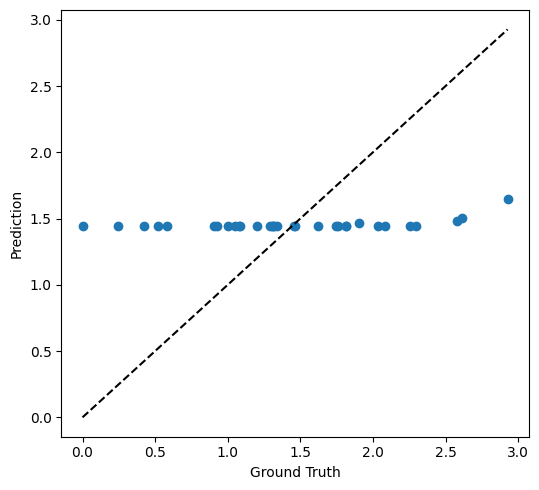

In [101]:
# plot parity plot
import matplotlib.pyplot as plt
import numpy as np
model.eval()
model.to('cuda')
truths = []
preds = []
with torch.no_grad():
    for graphs in dm.test_dataloader():
        graphs = graphs.to('cuda')
        y = graphs.y
        y_pred = model(graphs)
        truths.append(y.cpu().numpy())
        preds.append(y_pred.cpu().numpy())
        break
truths = np.concatenate(truths).tolist()
preds = np.concatenate(preds).tolist()

plt.figure(figsize=(5.5, 5))
plt.scatter(truths, preds)
plt.plot([min(truths), max(truths)], [min(truths), max(truths)], c='k', ls='--')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.tight_layout()
plt.savefig('snumat-painn.png', dpi=300)